In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
df = pd.read_csv('../../files/fcstapismb_stgeslstr_202103261342.csv')

In [3]:
df.head()

,clientid,pnme,amt,cost,netsales,trsdate,mnth,yrs
0,Olist008,Accessories,1.0,27.354,45.0,2017-03-31,3.0,2017.0
1,Olist008,Accessories,1.0,6.888,11.5,2017-03-31,3.0,2017.0
2,Olist008,Accessories,1.0,4.569,12.0,2017-04-01,4.0,2017.0
3,Olist008,Accessories,1.0,4.569,12.0,2017-04-02,4.0,2017.0
4,Olist008,Accessories,2.0,13.776,23.0,2017-04-02,4.0,2017.0


In [4]:
df.pnme.unique()

array(['Accessories', 'Additives And Fluids', 'Batteries',
       'Biscuits And Wafer', 'Canisters', 'Cereals',
       'Chewing Gum And Candy', 'Chips', 'Chocolates', 'Cigarettes',
       'Coal', 'Cold Alcoholic Beverages', 'Condom', 'Covers',
       'Dairy Products And Materials', 'Derivatives Peanuts', 'Energy',
       'Extinguisher', 'Filters', 'Flavoring', 'Fuel',
       'Hot Alcoholic Beverages', 'Juices And Soft Drinks', 'Lubricant',
       'Mate Herb', 'Pastas', 'Perfumery', 'Personal Hygiene', 'Pickets',
       'Popcorn', 'Popsicle And Ice Creams', 'Salted Biscuit', 'Several',
       'Slippers', 'Sweet Coconut James', 'Tea Juice Cafe In Powder',
       'The Bakery', 'Toys', 'Water'], dtype=object)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3434758 entries, 0 to 3434757
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   clientid  object 
 1   pnme      object 
 2   amt       float64
 3   cost      float64
 4   netsales  float64
 5   trsdate   object 
 6   mnth      float64
 7   yrs       float64
dtypes: float64(5), object(3)
memory usage: 209.6+ MB


In [6]:
df.describe()

,amt,cost,netsales,mnth,yrs
count,3.434758e+06,3.434758e+06,3.434758e+06,3.434758e+06,3.434758e+06
mean,1.872451e+02,4.062002e+01,7.138341e+02,6.783326e+00,2.018801e+03
std,1.025515e+03,2.118966e+02,3.995539e+03,3.682779e+00,5.938062e-01
min,9.000000e-03,-2.400000e-01,1.000000e-01,1.000000e+00,2.017000e+03
25%,1.000000e+00,1.754000e+00,3.500000e+00,3.000000e+00,2.019000e+03
50%,1.000000e+00,4.602000e+00,8.000000e+00,7.000000e+00,2.019000e+03
75%,2.000000e+00,1.066800e+01,2.000000e+01,1.000000e+01,2.019000e+03
max,5.942805e+04,7.877909e+03,2.198196e+05,1.200000e+01,2.020000e+03


In [24]:
# flake8: noqa: E501

import numpy as np
from numpy.core.fromnumeric import mean
import pandas as pd
from pandas.core.indexes.api import get_objs_combined_axis
import pmdarima
from datetime import datetime
import typing
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error # upgrade to the the latest scikit-learn pip install -U scikit-learn
import random
import copy

from abc import ABC, abstractmethod

class ModelWrapper(ABC):
    def __init__(self, **kwargs):
        try:
            self.__model = kwargs['model']
        except:
            self.__model = None
        
    @abstractmethod
    def fit(self, x):
        pass

    @abstractmethod
    def predict(self, n):
        pass
    def get_model(self):
        return self.__model
    def __str__(self):
        return "ModelWrapper for '{}'".format(str(self.__model))


class AutoArimaWrapper(ModelWrapper):
    def __init__(self, **kwargs):
        self.__kwargs = kwargs
        super().__init__(**kwargs)

    def fit(self, y: typing.Union[list, np.array]):
        kwargs = self.__kwargs.copy()
        try:
            kwargs.pop('y')
        except:
            pass
        self.__model = pmdarima.auto_arima(y=y, **kwargs)

    def predict(self, *args, **kwargs):
        return self.__model.predict(*args, **kwargs)

    def get_conf_int(self, *args, **kwargs):
        _, conf_int = self.__model.predict(*args, return_conf_int=True, **kwargs)
        return conf_int

class KerasWrapper(ModelWrapper):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)




## Changes to be made
## 1 would like to add an argument 

class TSFM(object):
    def __init__(self,
                 df: pd.core.frame.DataFrame, #df is now daily data
                 n_pred_period: int,
                 date_variable: typing.Union[int, str],
                 target_variable: typing.Union[int, str],
                 value_variable: typing.Union[int, str],
                 stop_date: str,         # stop date of train set, to split df to train and test sets
                 model_wrapper: ModelWrapper,
                 input_is_monthly: bool, 
                 output_is_monthly: bool,
                 section_list: list = None,
                 alpha: float = 0.05,):
                #  stepwise: bool = True,
                # cycle_length: int = 12,
                #  start_order: tuple = (0, 1, 0),
                #  max_order: tuple = (4, 2, 5),
                #  start_seasonal_order: tuple = (0, 1, 0),
                #  max_seasonal_order: tuple = (2, 2, 4)):
        self.target_variable = target_variable
        # self.n_pred_period = n_pred_period + abs((datetime.strptime(df[date_variable].to_numpy()[-1])  - datetime.strptime(stop_date, "%Y-%m-%d")).days)
        self.n_pred_period = n_pred_period
        self.stop_date = stop_date
        self.model_wrapper = model_wrapper
        self.input_is_monthly = input_is_monthly
        self.output_is_monthly = output_is_monthly
        self.alpha = alpha
        # self.stepwise = stepwise
        # self.start_order = start_order
        # self.max_order = max_order
        # self.start_seasonal_order = start_seasonal_order
        # self.max_seasonal_order = max_seasonal_order

        self.is_log_transformed_dict = dict()
        self.pred_dict = dict()
        self.pred_ic_dict = dict()
        self.adjusted_pred_dict = dict()
        self.adjusted_pred_ic_dict = dict()

        # train and test df must have date as index, and 2 columns: sections(e.g. territory) and values(e.g. order_volume)
        if type(date_variable) is int:
            date_variable = df.columns[date_variable]
        if type(value_variable) is int:
            value_variable = df.columns[value_variable]
        if type(target_variable) is int:
            target_variable = df.columns[target_variable]
        # Select relevant columns for train and test df, create empty pred df
        self.columns = [date_variable, target_variable, value_variable]
        df[self.columns[0]] = pd.to_datetime(df[self.columns[0]])
        

        
        if input_is_monthly and not output_is_monthly:
            print("Monthly to daily is not yet supported")
            return
        self.df = df.copy()

        # keys: sections(territories), value: list(train, test, pred), for easy storing and fetching data
        self.df_dict = dict()
        self.model_dict = dict()
        self.adjusted_model_dict = dict()

        # Iterate through the unique sections
        self.section_list = section_list
        if self.section_list is None:
            self.section_list = df[target_variable].unique()
        for section in self.section_list:
            self.is_log_transformed_dict[section] = False
            models = self.__train_models(section = section)
            if self.__have_negative_prediction(models=models):
                print("Negative prediction detected in", section)
                self.is_log_transformed_dict[section] = True
                models = self.__train_models(section = section)
            (model, adjusted_model) = models
            self.model_dict[section] = model
            self.adjusted_model_dict[section] = adjusted_model
            self.pred_dict[section], self.pred_ic_dict[section] = self.__get_pred_data(section=section, return_conf_int=True, is_adjusted=False)
            self.adjusted_pred_dict[section], self.adjusted_pred_ic_dict[section] = self.__get_pred_data(section=section, return_conf_int=True, is_adjusted=True)

    # DF Getters--------------------------------------------------------------
    def get_actual_data(self, section: str, is_adjusted: bool, is_log_transformed: bool = None) -> pd.core.frame.DataFrame:
        '''
        Returns the input data of a section with or without transformations.
        * section: str: an element in the unique list of target variables.
        * is_adjusted: bool: determine if the returning data is adjusted by the anomally filter.
        * is_log_transformed: bool = None: determine if the returning data is log transformed. If is None then it's value is determined by self.is_log_transformed_dict[section]
        '''
        agg_df = self.df[self.columns].groupby(self.columns[0:2], as_index=False).sum().copy()
        agg_df = agg_df.query(self.columns[1] + "==" + "'" + section + "'")[[self.columns[0], self.columns[2]]]
        # agg_df.set_index(self.columns[0], inplace=True)
        if not self.input_is_monthly and self.output_is_monthly:
            full_daily_df, remainder_daily_df = self.get_full_month_data(df=agg_df.copy())
            agg_df = TSFM.to_monthly(full_daily_df.set_index(self.columns[0], inplace=False)).reset_index(inplace=False)
        if is_adjusted and self.output_is_monthly:
            agg_df = self.anomaly_filter(agg_df, alpha = self.alpha)
        if is_log_transformed is None:
            is_log_transformed = self.is_log_transformed_dict[section]
        if is_log_transformed:
            agg_df = TSFM.log_transform(agg_df)
        return agg_df

    def get_train_data(self, section: str):
        '''
        Returns the training data for the anomaly filter method.
        * section: str: an element in the unique list of target variables.
        '''
        actual_df = self.get_actual_data(section, is_adjusted=False)
        return actual_df.iloc[lambda x: x.index <= self.stop_date].copy()

    def get_test_data(self, section: str, ):
        actual_df = self.get_actual_data(section, is_adjusted=False)
        return actual_df.iloc[lambda x: x.index > self.stop_date].copy()

    def get_pred_data(self, section: str, is_adjusted: bool, return_conf_int: bool = False):
        pred, ic = None, None
        if is_adjusted:
            pred, ic = self.adjusted_pred_dict[section], self.adjusted_pred_ic_dict[section]
        else:
            pred, ic = self.pred_dict[section], self.pred_ic_dict[section]
        if return_conf_int:
            return pred, ic
        return pred

    def get_full_month_data(self, df):
        max_date = df[self.columns[0]].max()
        if self.__is_last_day_of_month(max_date):
            return df, None
        new_date =  max_date.year + '-' + max_date.month + '-' + max_date.day
        return df.query(self.columns[0] + "<'" + new_date + "'"), df.query(self.columns[0] + ">='" + new_date + "'")
        

    def __is_last_day_of_month(self, date):
        next_day = date + pd.DateOffset(days=1)
        if date.month == next_day.month:
            return False
        return True


    def __get_pred_data(self, section: str, return_conf_int: bool = False, is_adjusted: bool = True):
        actual_df = self.get_actual_data(section, False)
        model = self.get_model(section=section, is_adjusted=is_adjusted)
        if self.output_is_monthly:
            freq = 'MS'
        else:
            freq = 'D'
        if model is None:
            print("Model of", section, "section was not initiated. Might due to insufficient training data.")
            return None
        pred  = model.predict(self.n_pred_period)
        conf_int = model.get_conf_int(self.n_pred_period)
        temp_pred_df = pd.DataFrame(
            data={
                self.columns[0]: pd.date_range(max(actual_df[self.columns[0]]),freq=freq,periods=self.n_pred_period+1)[1:],
                self.columns[1]: [section for x in range(len(pred))],
                self.columns[-1]: pred})  # Use numbers inplace of future dates for now)
        temp_pred_df = temp_pred_df[[self.columns[0], self.columns[2]]]
        # temp_pred_df.set_index(self.columns[0], inplace=True)
        if self.is_log_transformed_dict[section]:
            temp_pred_df = self.exp_transform(temp_pred_df)
        if return_conf_int:
            return temp_pred_df.copy(), conf_int
        return temp_pred_df.copy()

    def get_pred_df(self):
        '''
        function to be called in the backend to get pred data from all sections
        '''
        return_df = pd.DataFrame(columns=self.columns)
        for section in self.section_list:
            actual_pred = self.get_pred_data(section, is_adjusted=False)
            adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)
            pred = pd.DataFrame(data={actual_pred.columns[0]: actual_pred[actual_pred.columns[0]].to_numpy(), "value2": adjusted_actual_pred[adjusted_actual_pred.columns[0]].to_numpy()},
                                index = actual_pred.index)
            # pred.reset_index(inplace=True)
            pred[self.target_variable] = [section for x in range(pred.shape[0])]
            return_df = return_df.append(pred, ignore_index=True)
        return_df.sort_values(by=[self.columns[1], self.columns[0]], inplace=True, ignore_index=True)
        return return_df

    # Model Getters----------------------------------------------------------
    def get_model(self, section: str, is_adjusted: bool):
        if is_adjusted:
            return self.adjusted_model_dict[section]
        return self.model_dict[section]
    
    # Plot Function-----------------------------------------------------------
    def plot(self, section: str):
        actual = self.get_actual_data(section, is_adjusted=False)
        adjusted_actual, conf_int_df = self.anomaly_filter(actual, return_conf_int=True, alpha = self.alpha)

        actual.set_index(self.columns[0], inplace=True)
        adjusted_actual.set_index(self.columns[0], inplace=True) 
        conf_int_df.set_index(self.columns[0], inplace=True)
        # pred, ci = self.get_pred_data(section, return_conf_int=True)

        actual_pred = self.get_pred_data(section, is_adjusted=False)
        adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)

        actual_pred.set_index(self.columns[0], inplace=True)
        adjusted_actual_pred.set_index(self.columns[0], inplace=True)

        fig, ax = plt.subplots(figsize=(14,6))
        ax.plot(actual.index, actual[actual.columns[0]].to_numpy(),label="Actual")   #Actuals This should come from original DS (all actuals)
        ax.plot(adjusted_actual.index, adjusted_actual[adjusted_actual.columns[0]].to_numpy(),'-g', label="Adjusted Actual")   
        # ax.plot(pred.index, pred[pred.columns[0]], '-r',alpha=0.75,label="Forecast")  ## Pred
        ax.fill_between(conf_int_df.index, conf_int_df.iloc[:, 0], conf_int_df.iloc[:, 1],alpha=0.3, color='b')  ## Conf intervals
        
        ax.plot(actual_pred.index, actual_pred.iloc[:, 0], '--b',alpha=0.75,label="Actual Forecast")
        ax.plot(adjusted_actual_pred.index, adjusted_actual_pred.iloc[:, 0], '--g',alpha=0.75,label="Adjusted Actual Forecast")
        plt.title('Forecast Model')
        plt.xlabel('Year')
        plt.ylabel('Forecast Accurary')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())

        plt.legend()
        plt.show()

    def anomaly_filter(self,
                       df: pd.core.frame.DataFrame,
                       return_conf_int: bool = False, 
                       n_rolling_period: int = 12,
                       alpha: float = 0.05):
        print("Applying anomaly filter...")
        df = df.copy()
        df.set_index(self.columns[0], inplace=True)
        train = df.iloc[lambda x: x.index <= self.stop_date]
        returning_ic_list = list()
        (start_p, start_d, start_q) = (0, 1, 0)
        (max_p, max_d, max_q) = (4, 2, 5)
        (start_P, start_D, start_Q) = (0, 1, 0)
        (max_P, max_D, max_Q) = (2, 2, 4)
        for i in range(train.shape[0], df.shape[0], n_rolling_period):
            arima_model = pmdarima.auto_arima(train[train.columns[0]],
                                                start_p=start_p, start_P=start_P,
                                                start_q=start_q, start_Q=start_Q,
                                                d=start_d, D=start_D,
                                                max_p=max_p, max_P=max_P,
                                                max_d=max_d, max_D=max_D,
                                                max_q=max_q, max_Q=max_Q,
                                                trace=True, m=12, stepwise=True)
            temp_actual_df = df.iloc[i:min(i+n_rolling_period, df.shape[0]), :].copy()
            temp_pred, ic_list = arima_model.predict(n_rolling_period, return_conf_int=True, alpha=alpha)
            print("ic_list", ic_list)
            for j in range(temp_actual_df.shape[0]):
                temp_actual = temp_actual_df.iloc[j, 0]
                ic = ic_list[j]
                if temp_actual < ic[0] or temp_actual > ic[1]:
                    temp_actual_df.iloc[j, 0] = temp_pred[j]
            train = train.append(temp_actual_df)
            returning_ic_list = returning_ic_list + ic_list.tolist()
        train[train.columns[0]] = train[train.columns[0]].astype('float')
        train = train.asfreq('MS')
        if return_conf_int:
            returning_ic_list = np.array(returning_ic_list)
            print("returning_ic_list", returning_ic_list)
            ic_df = pd.DataFrame(
                data={
                    'lower': returning_ic_list[:, 0],
                    'upper': returning_ic_list[:, 1],
                },
                index=pd.Index(data=pd.date_range(self.stop_date,freq='MS',periods=returning_ic_list.shape[0]+1)[1:], name=self.columns[0])
            )
            return train.reset_index(inplace=False).copy(), ic_df.reset_index(inplace=False).copy()
        return train.reset_index(inplace=False).copy()
    
    def cross_validate(self,section: str, is_adjusted: bool):
        actual_df = self.get_actual_data(section, is_adjusted)
        actual_arr = actual_df[actual_df.columns[0]].to_numpy(dtype='float')
        trained_model = self.get_model(section, is_adjusted)
        order = trained_model.order
        seasonal_order = trained_model.seasonal_order

        model = copy.copy(self.model_wrapper)
        MAE = list()
        MAPE = list()
        tscv = TimeSeriesSplit(10)
        for train_index, test_index in tscv.split(X=actual_df.index):
            if len(train_index) >= 24:
                print("train_index = {}".format(train_index))
                print("test_index = {}".format(test_index))
                train = actual_arr[train_index]
                test = actual_arr[test_index]
                print("train = {}".format(train))
                print("test = {}".format(test))
                model.fit(train)
                pred = model.predict(len(test))
                mae = mean_absolute_error(test, pred)
                mape = mean_absolute_percentage_error(test, pred)
                MAE.append(mae)
                MAPE.append(mape)
                
                print("MAE = {}".format(mae))
                print("MAPE = {}".format(mape))
                print("-"*50)
            else:
                pass
        print("MAE = {}".format(MAE))
        print("MAPE = {}".format(MAPE))
        print("Average MAE = {}".format(np.mean(MAE)))
        print("Average MAPE = {}".format(np.mean(MAPE)))

    def __train_models(self, section: str) -> tuple:
        # (start_p, start_d, start_q) = self.start_order
        # (max_p, max_d, max_q) = self.max_order
        # (start_P, start_D, start_Q) = self.start_seasonal_order
        # (max_P, max_D, max_Q) = self.max_seasonal_order
    
        print("Inspecting", section, "...")
        temp_actual_df = self.get_actual_data(section=section, is_adjusted=False, is_log_transformed=self.is_log_transformed_dict[section])
        temp_adjusted_actual_df = self.get_actual_data(section=section, is_adjusted=True, is_log_transformed=self.is_log_transformed_dict[section])
        if temp_actual_df.shape[0] >= 2 * 12:
            # train actual data
            print("Training", temp_actual_df.shape[0], "actual records ...")
            model_wrapper = copy.copy(self.model_wrapper)
            model_wrapper.fit(temp_actual_df[temp_actual_df.columns[-1]])

            # train adjusted actual data
            print("Training", temp_adjusted_actual_df.shape[0], "adjusted actual records ...")
            adjusted_model_wrapper = copy.copy(self.model_wrapper)
            adjusted_model_wrapper.fit(temp_adjusted_actual_df[temp_adjusted_actual_df.columns[-1]])
            return model_wrapper, adjusted_model_wrapper
        print("Number of data points in Section", section, "is too small (" + str(
            temp_actual_df.shape[0]) + ". Must be at least twice the declared cycle length.")
        return None, None

    def __have_negative_prediction(self, models: tuple) -> bool:
        (model, adjusted_model) = models
        if model is None or adjusted_model is None:
            return False
        pred = model.predict(self.n_pred_period)
        adjusted_pred = adjusted_model.predict(self.n_pred_period)
        if min(min(pred), min(adjusted_pred)) < 0:
            return True
        return False

    @staticmethod
    def log_transform(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        '''
        df has 1 value column and has dates as indeces
        '''
        value_arr = df.loc[:, df.columns[0]].values.copy()
        value_arr[value_arr < 1] = 1 # avoid negative results from transformation
        value_arr = np.log(value_arr)
        return  pd.DataFrame(index=df.index, data={df.columns[0]: value_arr})
    
    @staticmethod
    def exp_transform(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        '''
        df has 1 value column and has dates as indeces
        '''
        value_arr = df.loc[:, df.columns[0]].values.copy()
        value_arr = np.exp(value_arr)
        return  pd.DataFrame(index=df.index, data={df.columns[0]: value_arr})

    @classmethod
    def to_monthly(cls, df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        return df.resample('MS').sum()

    def foo():
        return


In [25]:
auto_arima_wrapper = AutoArimaWrapper(start_p=0, start_P=0,
                                        d=1, D=1,
                                        start_q=0, start_Q=0,
                                        max_p=4, max_P=2,
                                        max_d=2, max_D=2,
                                        max_q=5, max_Q=4,
                                        trace=True, m=12,stepwise=True)

In [26]:
tsfm = TSFM(df=df, n_pred_period=24, date_variable='trsdate', target_variable='pnme', value_variable='amt', stop_date="2019-03-01", model_wrapper=auto_arima_wrapper, input_is_monthly=False, output_is_monthly=True ,section_list=["Accessories", "Filters"])

Inspecting Accessories ...
Applying anomaly filter...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=162.094, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=165.569, Time=0.89 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=164.065, Time=0.21 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=164.063, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=166.061, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=163.617, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=163.795, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=165.391, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=161.324, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=163.324, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=163.315, Time=1.06 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=165.323, Time=0.40 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=160.26

Applying anomaly filter...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=162.094, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=165.569, Time=1.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=164.065, Time=0.12 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=164.063, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=166.061, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=163.617, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=163.795, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=165.391, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=161.324, Time=0.01 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=163.324, Time=0.16 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=163.315, Time=0.67 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=165.323, Time=0.42 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=160.262, Time=0.17 sec
 ARIMA(1,1

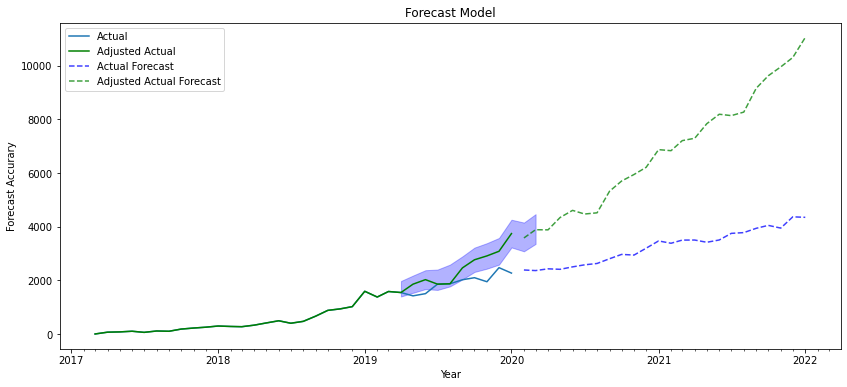

In [27]:
tsfm.plot("Accessories")